In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


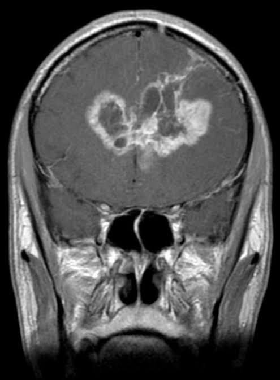

In [ ]:
fill='/content/drive/MyDrive/Deep Db/Testing/glioma_tumor/image(1).jpg'
from tensorflow.keras.preprocessing import image
img=image.load_img(fill,target_size=(380,280))
img

In [ ]:
def plot_images(direction):
    list_direction=os.listdir(direction)

    plt.figure(figsize=(16,10))

    for i in range(1,10):
        plt.subplot(3,3,i)
        img=plt.imread(os.path.join(direction,list_direction[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

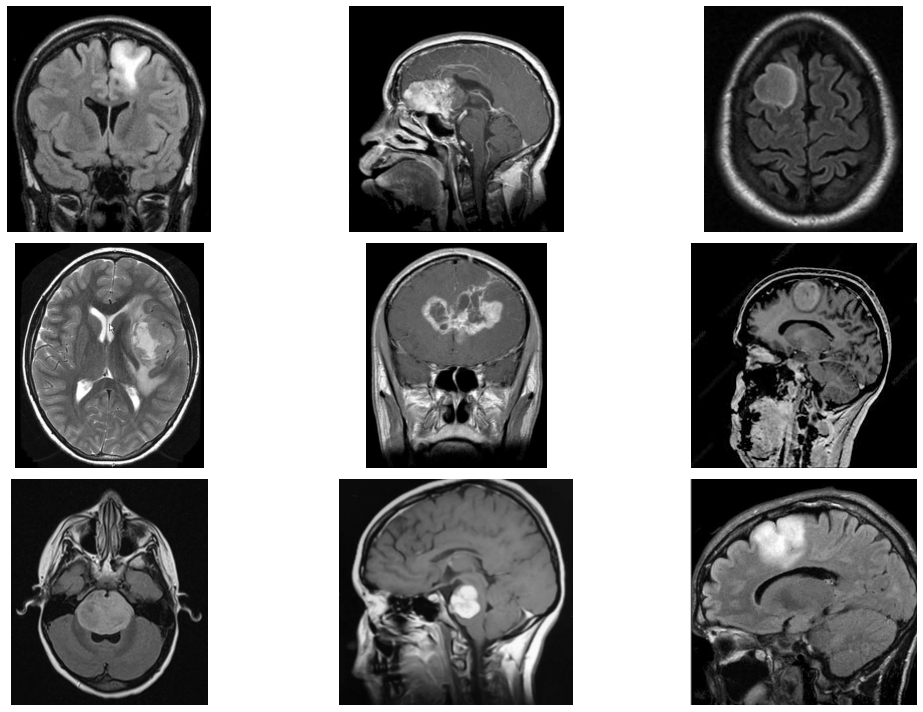

In [ ]:
glioma_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/glioma_tumor'
plot_images(glioma_tumor_dir)

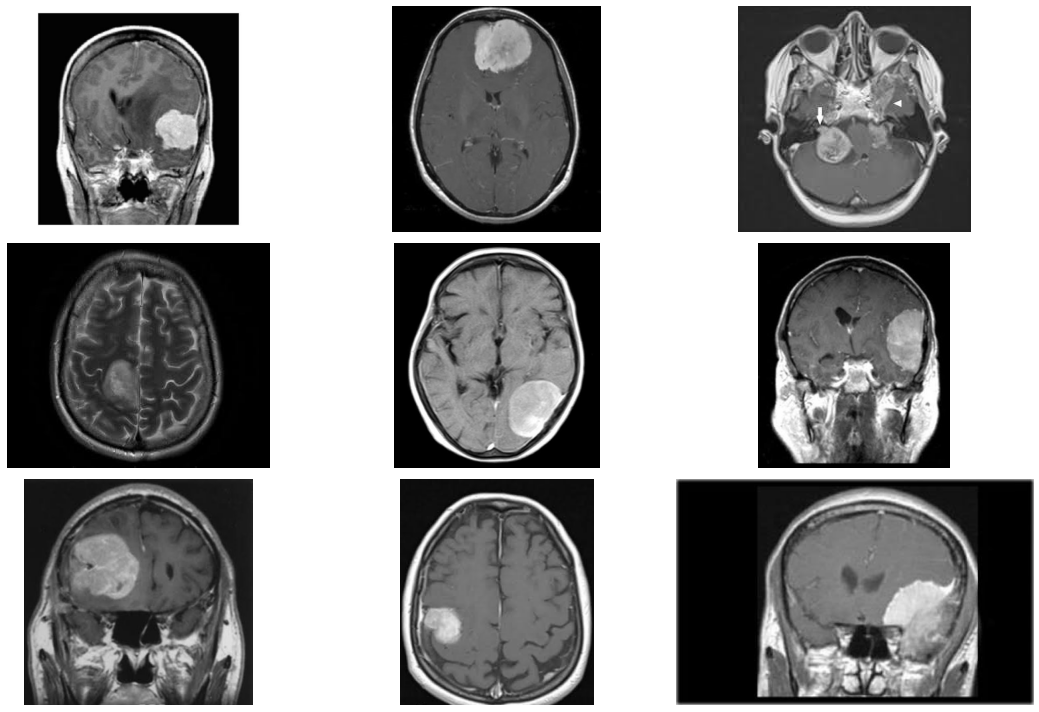

In [ ]:
meningioma_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/meningioma_tumor'
plot_images(meningioma_tumor_dir)

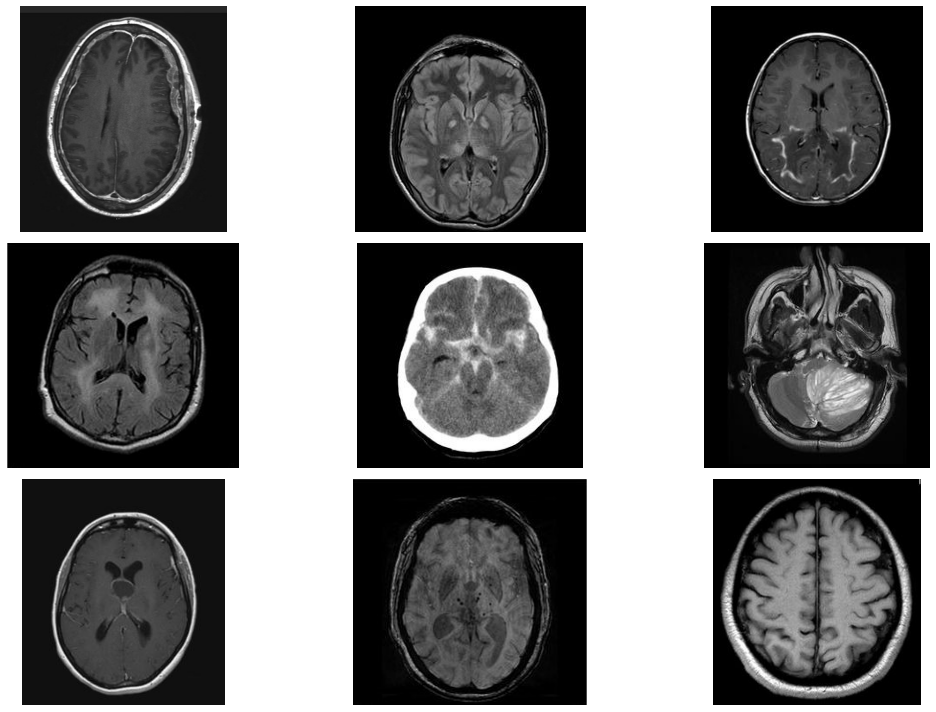

In [ ]:
No_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/no_tumor'
plot_images(No_tumor_dir)

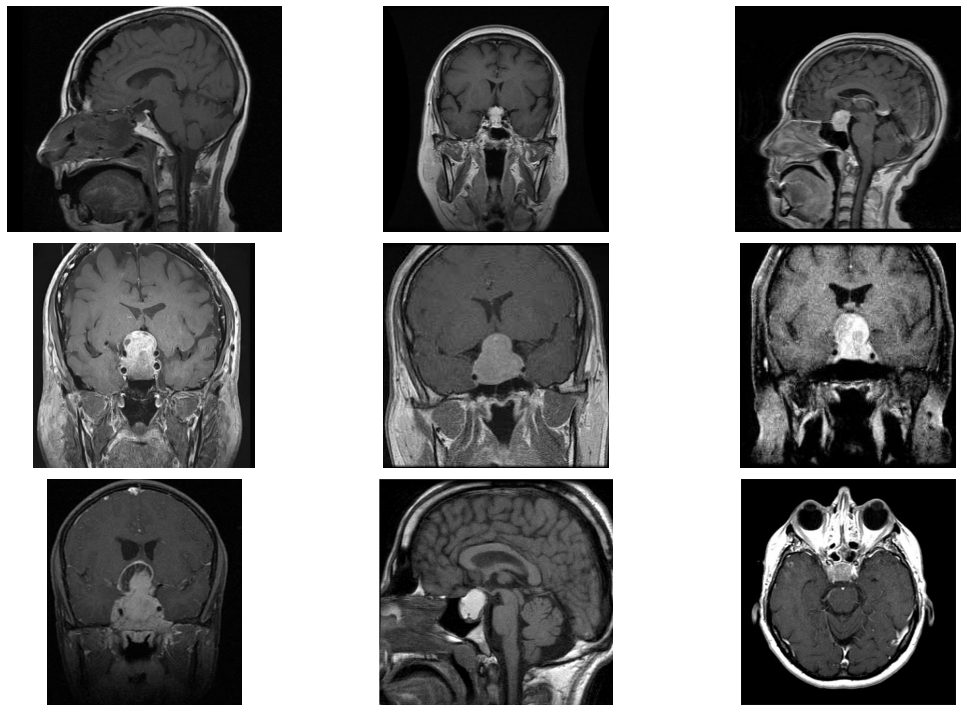

In [ ]:
Pituitary_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/pituitary_tumor'
plot_images(Pituitary_tumor_dir)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 73% 63.0M/86.8M [00:00<00:00, 139MB/s]
100% 86.8M/86.8M [00:00<00:00, 154MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/brain-tumor-classification-mri.zip','r') as zip:
  zip.extractall('/content')

In [ ]:
X_train = []
y_train = []
image_size = 224
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
y_train

array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', ...,
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [ ]:
classes=["glioma_tumor","pituitary_tumor","meningioma tumor","no tumor"]

In [ ]:
X_train,y_train=shuffle(X_train,y_train,random_state=1)
X_train.shape

(3264, 224, 224, 3)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
images_dict = dict()
x_train_dict=dict()
for i, l in enumerate(y_train_new):
  if len(images_dict)==4:
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((224, 224,3))
images_dict = dict(sorted(images_dict.items()))
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
x_train_each_class = np.asarray(x_trian_each_class)

# example image for each class for test set
X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==4:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [ ]:
import tensorflow as tf

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides):
        super(ConvBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, input_shape=(224, 224, 3))
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

        self.conv_blocks = tf.keras.Sequential([
            ConvBlock(64, (4, 4), (2, 2)),
            ConvBlock(64, (3, 3), (1, 1)),
            ConvBlock(128, (4, 4), (2, 2)),
            ConvBlock(128, (3, 3), (1, 1)),
            ConvBlock(256, (4, 4), (2, 2)),
            ConvBlock(256, (3, 3), (1, 1)),
            ConvBlock(512, (4, 4), (2, 2))
        ])

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1024)
        self.fc2 = tf.keras.layers.Dense(4, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.leaky_relu(x)
        x = self.conv_blocks(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        return x

# Creating an instance of the discriminator
model = Discriminator()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create a Transformer layer
class TransformerLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerLayer, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Global average pooling to reduce spatial dimensions
        ffn_output = layers.GlobalAveragePooling2D()(ffn_output)

        return self.layernorm2(ffn_output)

# Create the combined model
def create_transformer_cnn_model(input_shape, num_classes):
    embed_dim = 32  # Adjust based on your needs
    num_heads = 2   # Adjust based on your needs
    ff_dim = 32     # Adjust based on your needs
    input_layer = layers.Input(shape=input_shape)

    # Transformer block
    transformer_block = TransformerLayer(embed_dim, num_heads, ff_dim)(input_layer)

    # CNN block
    cnn_block = layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
    cnn_block = layers.MaxPooling2D((2, 2))(cnn_block)
    cnn_block = layers.Flatten()(cnn_block)

    # Fully connected layers
    dense_layer = layers.Dense(128, activation='relu')(cnn_block)

    # Concatenate Transformer and CNN blocks
    combined = layers.concatenate([transformer_block, dense_layer])

    output_layer = layers.Dense(num_classes, activation='softmax')(combined)

    # Model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Create the model
model = create_transformer_cnn_model((224, 224, 3), 4)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 flatten (Flatten)           (None, 788544)               0         ['max_pooling2d[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Nadam(1e-3), metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs =20, verbose=1, batch_size=8,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20


In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Verify the shape and data type after conversion
print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("X_test shape:", X_test.shape, "dtype:", X_test.dtype)
model.compile(loss='categorical_crossentropy',optimizer =tf.keras.optimizers.RMSprop(), metrics= ['accuracy'])
history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs =11, verbose=1, batch_size=32)

X_train shape: (2937, 224, 224, 3) dtype: float32
X_test shape: (327, 224, 224, 3) dtype: float32
Epoch 1/11
92/92 [==============================] - 42s 291ms/step - loss: 60.7914 - accuracy: 0.3395 - val_loss: 26.4738 - val_accuracy: 0.5443
Epoch 2/11
92/92 [==============================] - 22s 242ms/step - loss: 9.2500 - accuracy: 0.4464 - val_loss: 4.4803 - val_accuracy: 0.3547
Epoch 3/11
92/92 [==============================] - 23s 250ms/step - loss: 4.0205 - accuracy: 0.5598 - val_loss: 1.6404 - val_accuracy: 0.4281
Epoch 4/11
92/92 [==============================] - 24s 259ms/step - loss: 1.5048 - accuracy: 0.6486 - val_loss: 7.7930 - val_accuracy: 0.2661
Epoch 5/11
92/92 [==============================] - 24s 262ms/step - loss: 1.1177 - accuracy: 0.7137 - val_loss: 7.9234 - val_accuracy: 0.5107
Epoch 6/11
92/92 [==============================] - 24s 258ms/step - loss: 0.8917 - accuracy: 0.7600 - val_loss: 3.9728 - val_accuracy: 0.6269
Epoch 7/11
92/92 [========================

In [ ]:
y_test

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

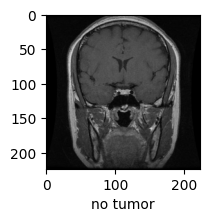

In [ ]:

plot_sample(X_train,y_train_new,0)

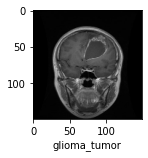

In [ ]:
plot_sample(X_train,y_train_new,6)

# **EfficientNetV2L**

In [ ]:
effnet = tf.keras.applications.EfficientNetV2L(weights='imagenet',include_top=False,input_shape=(150,150,3))

473176280/473176280 [==============================] - 5s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Nadam(1e-3), metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs =20, verbose=1, batch_size=8,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
368/368 [==============================] - ETA: 0s - loss: 0.7714 - accuracy: 0.7085
Epoch 1: val_accuracy improved from -inf to 0.73089, saving model to vgg16.h5


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


368/368 [==============================] - 500s 490ms/step - loss: 0.7714 - accuracy: 0.7085 - val_loss: 0.8543 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 2/20
368/368 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.8138
Epoch 2: val_accuracy improved from 0.73089 to 0.90214, saving model to vgg16.h5
368/368 [==============================] - 191s 520ms/step - loss: 0.5282 - accuracy: 0.8138 - val_loss: 0.3272 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 3/20
368/368 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8822
Epoch 3: val_accuracy did not improve from 0.90214
368/368 [==============================] - 151s 411ms/step - loss: 0.3578 - accuracy: 0.8822 - val_loss: 0.3999 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 4/20
368/368 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8999
Epoch 4: val_accuracy improved from 0.90214 to 0.92049, saving model to vgg16.h5
368/368 [==============================] - 200s 544ms/s

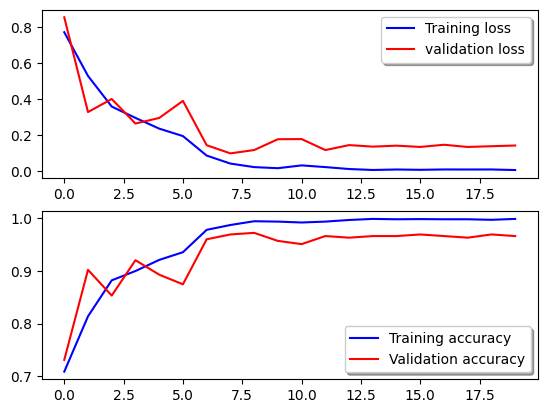

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png")

predict

In [ ]:
Y_pred=model.predict(X_test)

11/11 [==============================] - 13s 214ms/step


In [ ]:
Y_pred[:5]

array([[3.4090892e-05, 9.9996150e-01, 4.3895993e-06, 1.4839331e-09],
       [9.9994123e-01, 2.4354596e-05, 3.2777098e-05, 1.6300434e-06],
       [1.0753172e-09, 9.9925074e-08, 1.5959561e-07, 9.9999976e-01],
       [5.4748654e-08, 1.5896795e-08, 5.5586452e-07, 9.9999928e-01],
       [2.5197030e-06, 4.7726685e-06, 1.2126988e-08, 9.9999273e-01]],
      dtype=float32)

In [ ]:
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
y_class[:5]

[1, 0, 3, 3, 3]

In [ ]:
y_test_new[:5]

[1, 0, 3, 3, 3]

In [ ]:
plot_sample(X_test,y_test_new,5)

NameError: ignored

In [ ]:
classes[y_class[5]]

'meningioma tumor'

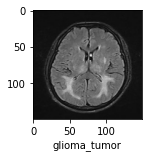

In [ ]:
plot_sample(X_train,y_test_new,1)

In [ ]:
classes[y_class[1]]

'glioma_tumor'

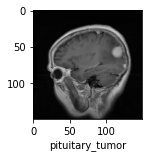

In [ ]:
plot_sample(X_train,y_test_new,0)

In [ ]:
classes[y_class[0]]

'pituitary_tumor'

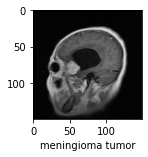

In [ ]:
plot_sample(X_train,y_test_new,11 )

In [ ]:
classes[y_class[11]]

'meningioma tumor'

Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

1/1 [==============================] - 1s 806ms/step


array([0, 1, 2, 3])

In [ ]:
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 4, figsize=(16, 15))
  axes = axes.flatten()

  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[int(k)]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (classes[k], classes[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()


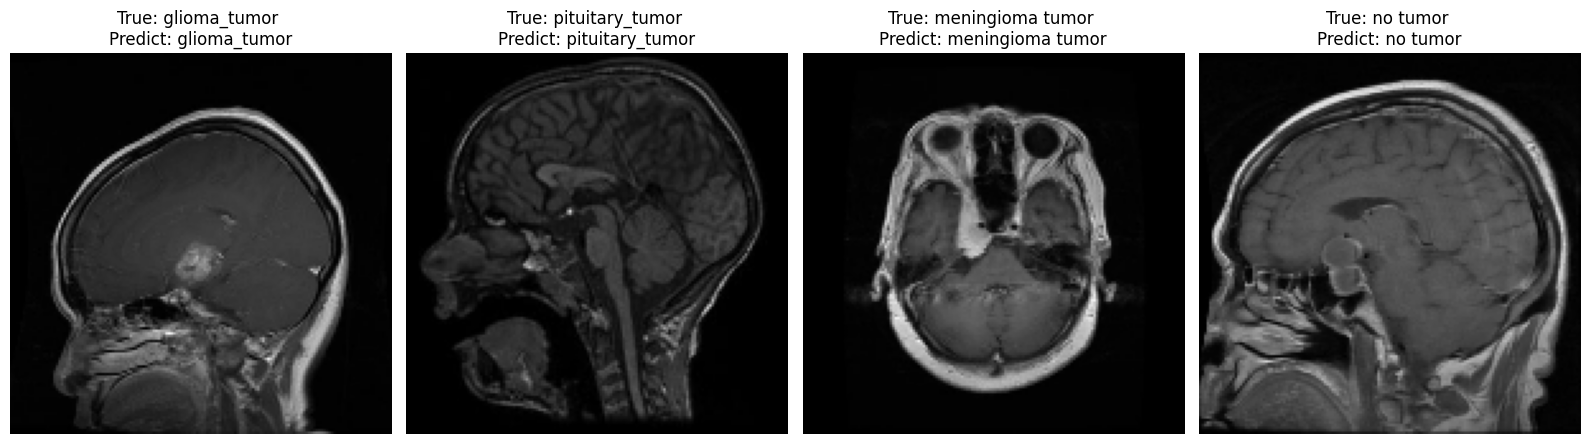

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_actual_predicted(images_dict, predicted_class)
plt.savefig('predited.png',dpi=300)


Shap

S

In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [ ]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [00:53<00:13, 13.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [01:16<00:00, 17.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [01:38, 24.69s/it]


(4, 150, 150, 3, 4)

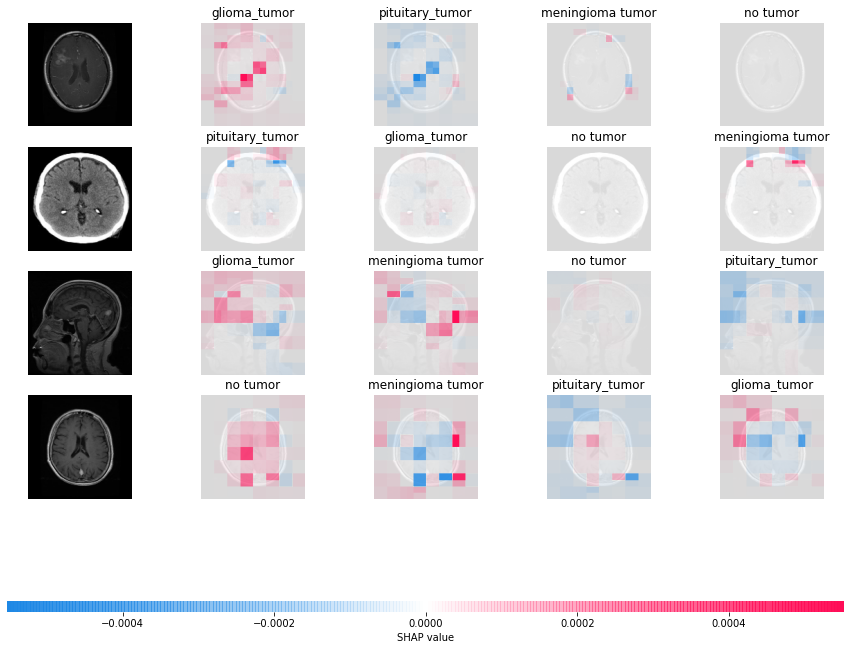

In [ ]:
shap.image_plot(shap_values)

Report,Confution Matrix

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        88
           1       0.96      0.98      0.97        50
           2       0.94      0.97      0.95        96
           3       0.99      0.99      0.99        93

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[82,  2,  4,  0],
       [ 0, 49,  1,  0],
       [ 2,  0, 93,  1],
       [ 0,  0,  1, 92]], dtype=int32)>

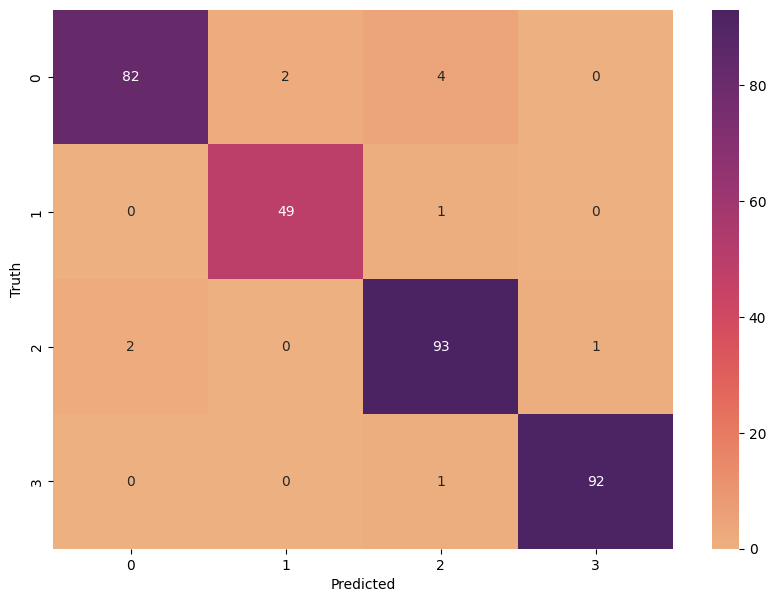

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(".png")


# **vGG16**

In [ ]:
vgg=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3)
)
vgg.trainable=False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout


In [ ]:
model = Sequential()
model.add(vgg)
model.add(Conv2D(filters=512,
              kernel_size=(3, 3),
              padding='same',
              activation='relu',
              input_shape=(150,150,3),
              name='conv3_1'))
model.add(Conv2D(filters=512,
              kernel_size=(3, 3),
                  padding='same',
              activation='relu',
              name='conv3_2'))
model.add(Conv2D(filters=512,
              kernel_size=(3, 3),
                  padding='same',
              activation='relu',
              name='conv3_3'))

model.add(MaxPooling2D(pool_size=(2,2),
                   strides=(2,2),
                   name='max_pooling2d_3'))
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5, name='dropout_4'))
model.add(Dense(4, activation='softmax', name='output'))


In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv3_1 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 conv3_2 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 conv3_3 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                     

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 2.3188 - accuracy: 0.6962
Epoch 1: val_accuracy improved from -inf to 0.87755, saving model to vgg16.h5
83/83 [==============================] - 10s 102ms/step - loss: 2.3188 - accuracy: 0.6962 - val_loss: 0.4198 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8687
Epoch 2: val_accuracy did not improve from 0.87755
83/83 [==============================] - 8s 101ms/step - loss: 0.3499 - accuracy: 0.8687 - val_loss: 0.4494 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9228
Epoch 3: val_accuracy improved from 0.87755 to 0.88095, saving model to vgg16.h5
83/83 [==============================] - 8s 100ms/step - loss: 0.2300 - accuracy: 0.9228 - val_loss: 0.3802 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.1748 

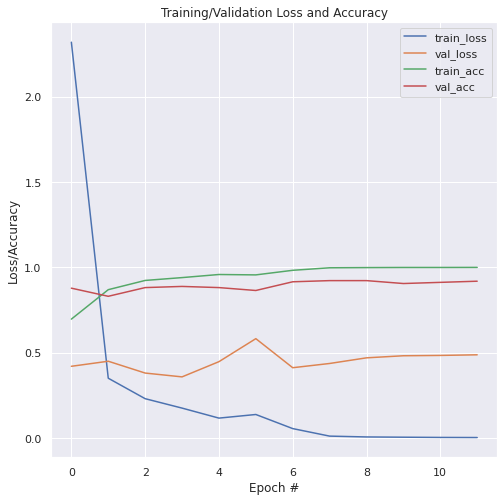

In [ ]:
EPOCHS=12
sns.set()
N = np.arange(0, EPOCHS)
plt.figure(figsize=(8,8))
plt.plot(N, model.history.history["loss"], label="train_loss")
plt.plot(N, model.history.history["val_loss"], label="val_loss")
plt.plot(N, model.history.history["accuracy"], label="train_acc")
plt.plot(N, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


predict


Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

array([0, 1, 3, 3])

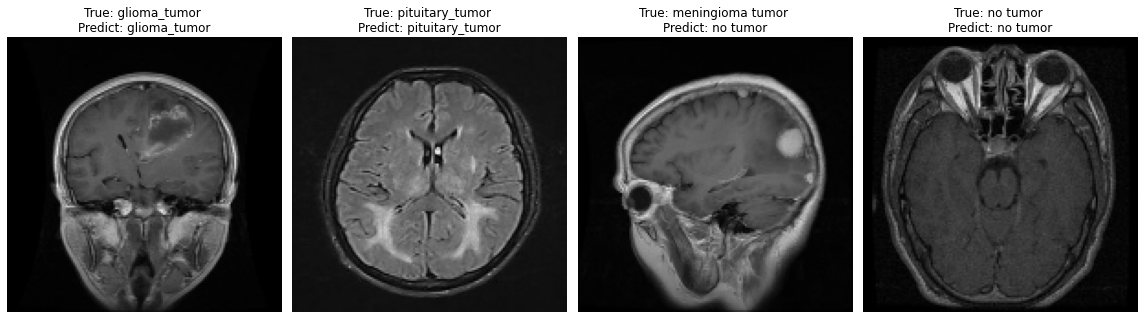

In [ ]:
plot_actual_predicted(images_dict, predicted_class)


In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [ ]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [00:24<00:03,  3.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [00:31<00:00,  5.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [00:39,  9.83s/it]


(4, 150, 150, 3, 4)

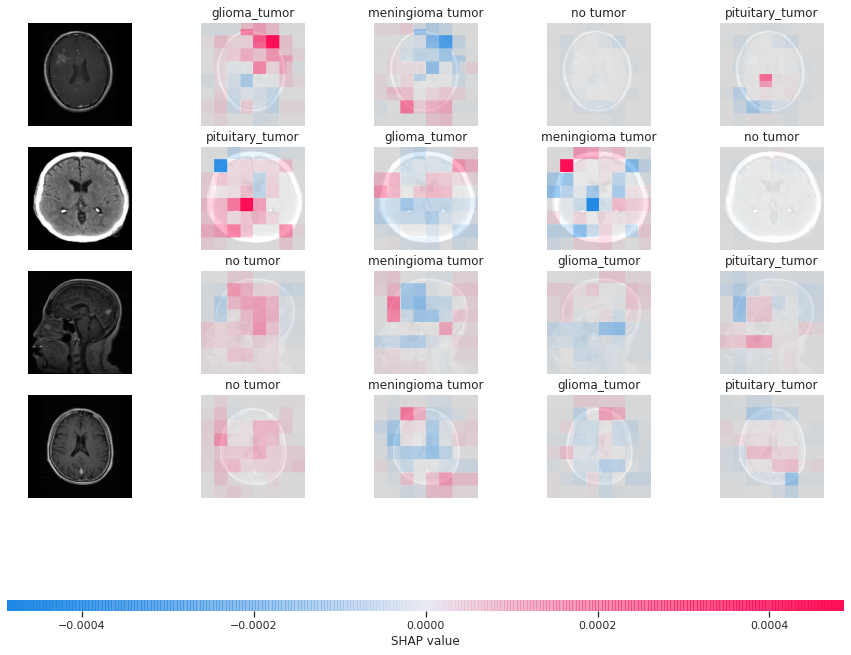

In [ ]:
shap.image_plot(shap_values)

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        88
           1       0.94      0.94      0.94        50
           2       0.88      0.88      0.88        96
           3       0.95      0.96      0.95        93

    accuracy                           0.91       327
   macro avg       0.91      0.91      0.91       327
weighted avg       0.91      0.91      0.91       327



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[78,  3,  7,  0],
       [ 2, 47,  0,  1],
       [ 8,  0, 84,  4],
       [ 0,  0,  4, 89]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

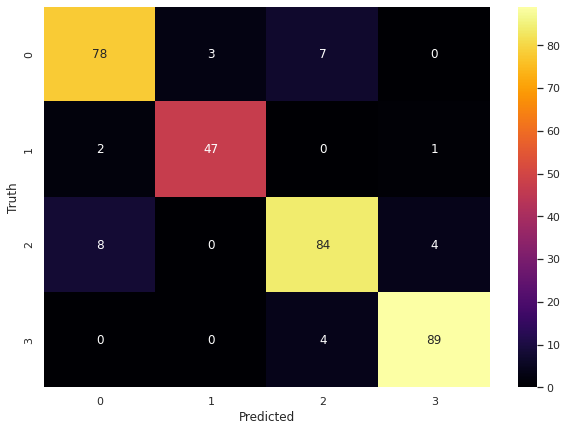

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='inferno')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
resnet= ResNet50(
    input_shape =(150,150,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [ ]:
modelmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.6916
Epoch 1: val_accuracy improved from -inf to 0.32653, saving model to vgg16.h5
83/83 [==============================] - 26s 216ms/step - loss: 0.9968 - accuracy: 0.6916 - val_loss: 14261.9658 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8593
Epoch 2: val_accuracy did not improve from 0.32653
83/83 [==============================] - 15s 176ms/step - loss: 0.3884 - accuracy: 0.8593 - val_loss: 6.9270 - val_accuracy: 0.2823 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9311
Epoch 3: val_accuracy did not improve from 0.32653

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [==============================] - 14s 175ms/step - loss: 0.2263 - accuracy: 0.9311 - val_loss: 2.9663 - val_accuracy: 0.2925 - lr: 0.0010
Epoch 4/12
83/83 [====

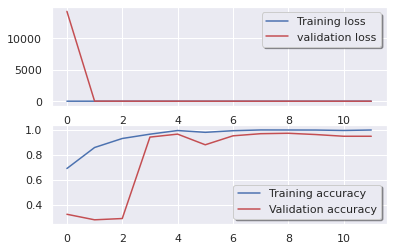

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png")

In [ ]:
Y_pred=model.predict(X_test)


In [ ]:
y_class=[np.argmax(x) for x in Y_pred]


In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        88
           1       0.94      0.98      0.96        50
           2       0.92      0.94      0.93        96
           3       0.97      1.00      0.98        93

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[78,  3,  7,  0],
       [ 0, 49,  1,  0],
       [ 3,  0, 90,  3],
       [ 0,  0,  0, 93]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

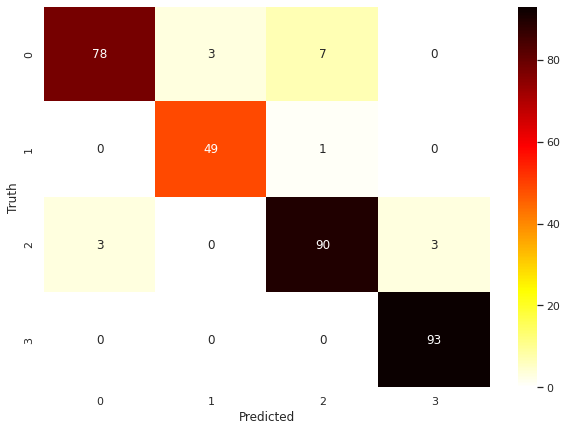

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='hot_r')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:

resnet= tf.keras.applications.resnet.ResNet101(
    input_shape =(224,224,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

171446536/171446536 [==============================] - 8s 0us/step


In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.6939
Epoch 1: val_accuracy improved from -inf to 0.32653, saving model to resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 160s 692ms/step - loss: 0.8737 - accuracy: 0.6939 - val_loss: 4986.9326 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8422
Epoch 2: val_accuracy improved from 0.32653 to 0.34694, saving model to resnet50.h5
83/83 [==============================] - 54s 651ms/step - loss: 0.4423 - accuracy: 0.8422 - val_loss: 5.9471 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8925
Epoch 3: val_accuracy did not improve from 0.34694
83/83 [==============================] - 47s 561ms/step - loss: 0.3456 - accuracy: 0.8925 - val_loss: 3.2514 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.8082
Epoch 4: val_accuracy did not improve from 0.34694

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [=========

In [ ]:
Y_pred=model.predict(X_test)
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='hot_r')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
resnet= tf.keras.applications.vgg19.VGG19(
    input_shape =(224,224,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 2.0749 - accuracy: 0.3042
Epoch 1: val_accuracy improved from -inf to 0.22449, saving model to resnet50.h5
83/83 [==============================] - 81s 683ms/step - loss: 2.0749 - accuracy: 0.3042 - val_loss: 1.2662 - val_accuracy: 0.2245 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.3348
Epoch 2: val_accuracy improved from 0.22449 to 0.24830, saving model to resnet50.h5
83/83 [==============================] - 41s 490ms/step - loss: 1.3439 - accuracy: 0.3348 - val_loss: 1.3486 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 1.2558 - accuracy: 0.3765
Epoch 3: val_accuracy improved from 0.24830 to 0.48299, saving model to resnet50.h5
83/83 [==============================] - 40s 483ms/step - loss: 1.2558 - accuracy: 0.3765 - val_loss: 1.1905 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 4/12
83/83 [================